# NTSB Aviation Accident Database Analysis

**Author:** Jeffrey Goett  
[LinkedIn](http://www.linkedin.com/in/jeffrey-g-3b3a83a)

## Overview
This project analyzes the Aviation Accident Database from the National Transportation Safety Board to identify the features of an airplane correlated to airplane safety.  The analysis finds the following:
- Airplanes with **turbo jet** or **turbo fan** engines tend to be involved in less severe accidents.
- **Narrow-body** and **wide-body** airplanes tend to be involved in less severe accidents than light-body airplanes
- Aircraft manufactured by **Airbus** are slightly less likely to be involved in accidents than those by Boeing

## Business Problem

![image info](./images/photo_plane_cover.png)
A company would like to purchase and lease airplanes, and wants to identify which features of an airplane are tied to its relative safety. When considering the safety of an aircraft, we will look at two different dimensions - how frequently is an airplane involved in an accident, and when it is in an accident, how  severe are the accidents?  

Ideally, this study will help us identify airplanes that are not frequently involved in an accident, and when they are, minimize the severity of the accident.  

In particular, this study will look at three features of an airplane, and determine how they affect the airplane safety.  It will look at the Aviation Database from the NTSB and answer these three questions will be addressed:
- Is accident severity related to the type of engine used on the airplane?
- Is accident severity related to the size of the airplane?
- Is the frequency of accidents related to the manufacturer of the aircraft?


## Data Understanding

The National Transportation Safety Board Accident Database records every accident that has occurred in the United States since roughly 1982.  Each record includes the date of the accident, the make, model, and engine type of the airplane involved, and the number of serious injuries and fatalities resulting from the accident.  

This study will consider an accident to be serious if it involves one or more serious injuries, and an accident to be fatal if it involves one or more fatalities.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
df = pd.read_csv("data/Aviation_Data.csv")

/var/folders/ym/68nrz1n97wj0gz5413bhpqs80000gn/T/ipykernel_54221/3414971824.py:1: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/Aviation_Data.csv")


In [3]:
df.head(3)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007


Additional data on each model of airplane is imported.  This helps to identify the category of airplane (narrow-body or wide-body), and whether the airplane is currently in production.

In [4]:
dtypes_def = {'Make':'str','Model':'str','In Production':'bool','Make-Norm':'str','Model-Norm':'str'}
planes_wide_body = pd.read_csv("data/wide-body-planes.csv",dtype=dtypes_def)
planes_narrow_body = pd.read_csv("data/narrow-body-planes.csv",dtype=dtypes_def)
planes_light_body = pd.read_csv("data/light-body-planes.csv",dtype=dtypes_def)

carriers = pd.read_csv("data/carriers.csv")

planes_all = pd.concat([planes_wide_body, planes_narrow_body, planes_light_body])
planes_all.set_index(np.arange(0,len(planes_all)),inplace=True)

df["Model"]=df["Model"].map(lambda x:str(x))

In [5]:
planes_all.head(3)

,Make-Key,Model-Key,Seating,In Production,Aircraft.Type,Make-Norm,Model-Norm
0,Airbus,300,172,False,wide-body,Airbus,A300
1,Airbus,310,164,False,wide-body,Airbus,A310
2,Airbus,330,242,True,wide-body,Airbus,A330


For example, here are the Boeing and Airbus planes currently in production.

In [6]:
filter1 = planes_all["In Production"]
filter2 = (planes_all["Make-Norm"] == "Boeing") | (planes_all["Make-Norm"] == "Airbus") 
planes_all.loc[filter1 & filter2].groupby(["Make-Norm","Model-Norm"]).count()

Make-Key  Model-Key  Seating  In Production  \
Make-Norm Model-Norm                                                
Airbus    A220               2          2        2              2   
          A319               2          2        2              2   
          A320               2          2        2              2   
          A321               2          2        2              2   
          A330               2          2        2              2   
          A350               1          1        1              1   
Boeing    737                1          1        1              1   
          767                1          1        1              1   
          777                1          1        1              1   
          787                1          1        1              1   

                      Aircraft.Type  
Make-Norm Model-Norm                 
Airbus    A220                    2  
          A319                    2  
          A320                    2  
          A321                    2  
          A330                    2  
          A350                    1  
Boeing    737                     1  
          767                     1  
          777                     1  
          787                     1

## Data Cleaning

### Impute Data

When the number of injuries and fatalities is blank, we will set it to 0.

In [7]:
df.loc[df["Total.Serious.Injuries"].isna(),"Total.Serious.Injuries"]=0
df.loc[df["Total.Fatal.Injuries"].isna(),"Total.Fatal.Injuries"]=0

### Normalize Make, Model, and Air Carrier

This code standardizes the name of the Make, Model, and Air Carrier used in the database

In [8]:
import code.data_preparation as dp

In [9]:
df["Make"] = dp.normalize_make(df,planes_all)
df["Model"] = dp.normalize_model(df,planes_all)
df["Air.carrier"] = dp.normalize_carrier(df,carriers)

### Add Aircraft Type and Production Status

We add the type of aircraft (narrow-body, wide-body, regional set, or light-body) to the database.  We also indicate whether the airplane is currently in production.

In [10]:
df["Aircraft.Type"] = dp.lookup_aircraft_type(df,planes_all)
df["In.Production"] = dp.lookup_production(df,planes_all)

### Format Date

Convert the string representation of Event.Date to a Pandas date-time object and store in same column.  Store the year in a new column "Year."

In [11]:
df["Event.Date"]=pd.to_datetime(df["Event.Date"], format="%Y-%m-%d")
df["Year"] = df["Event.Date"].dt.year

As an overview, we can graph the number of accidents over time:

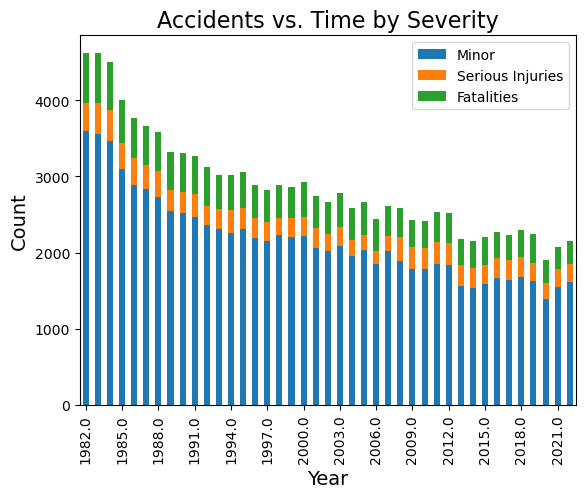

In [12]:
from matplotlib.ticker import FormatStrFormatter
filter_minor = (df["Total.Serious.Injuries"] == 0) & (df["Total.Fatal.Injuries"] == 0)
filter_serious = (df["Total.Serious.Injuries"] > 0) & (df["Total.Fatal.Injuries"] == 0)
filter_fatal = df["Total.Fatal.Injuries"] > 0

accident_all=df.groupby("Year").count()["Event.Id"]
accident_serious=df[filter_serious].groupby("Year").count()["Event.Id"]
accident_fatal=df[filter_fatal].groupby("Year").count()["Event.Id"]

accident_time=pd.concat([accident_all,accident_serious,accident_fatal],axis=1)
accident_time.columns= ["Minor","Serious Injuries","Fatalities"]

fig,ax=plt.subplots()
accident_time[accident_time.index>1981].plot.bar(stacked=True, ax=ax)

ax.set_title("Accidents vs. Time by Severity", fontsize=16)
ax.set_xlabel("Year",fontsize=14)
ax.set_ylabel("Count", fontsize=14)

tick_spacing = 3

ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%f'))

fig.savefig("images/accident_time.png",bbox_inches="tight")

## Data Analysis

### Accident Severity vs. Engine Type

We consider whether the type of airplane engine has a relationship to the severity of accident the plane is involved in.  Based on the graph below, we see a strong correlation between the type of engine and the proportion of fatal accidents an airplane is involved in.  Both turbo jet and turbo fan engine types are associated with fewer accidents involving fatalities.

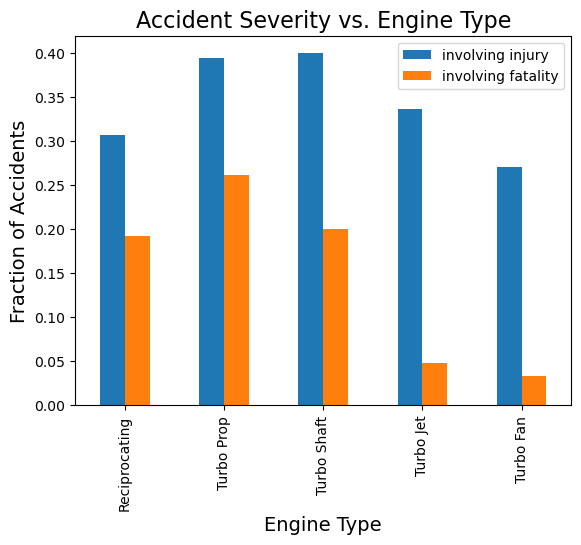

In [13]:
fig,ax=plt.subplots()
engine_analysis = pd.DataFrame()

filter = df["In.Production"]==True

filter2 = (df["Total.Serious.Injuries"]>0) | (df["Total.Fatal.Injuries"]>0)

engine_analysis["accident.all"] = df[filter].groupby("Engine.Type").count()["Event.Id"]
engine_analysis["accident.injury"] = df[filter & filter2].groupby("Engine.Type").count()["Event.Id"]
engine_analysis["accident.fatal"] = df[filter & df["Total.Fatal.Injuries"]>0].groupby("Engine.Type").count()["Event.Id"]

engine_analysis["ratio.injury"] = engine_analysis["accident.injury"]/engine_analysis["accident.all"]
engine_analysis["ratio.fatal"] = engine_analysis["accident.fatal"]/engine_analysis["accident.all"]


engines = ["Reciprocating","Turbo Prop","Turbo Shaft","Turbo Jet","Turbo Fan",]
engine_analysis.loc[engines,["ratio.injury","ratio.fatal"]].plot.bar(ax=ax)
engine_analysis

ax.set_title("Accident Severity vs. Engine Type", fontsize=16)
ax.set_xlabel("Engine Type",fontsize=14)
ax.set_ylabel("Fraction of Accidents", fontsize=14)
ax.legend(["involving injury","involving fatality"])

fig.savefig("images/engine_type.png",bbox_inches="tight")

### Accident Severity vs. Aircraft Type

We consider whether the type of airplane has a relationship to the severity of accident the plane is involved in.  Based on the graph below, we see a strong correlation between the type of airplane and the proportion of fatal accidents an airplane is involved in.  There is also a correlation between the type of airplane and the proportion of accidents involving an injury.

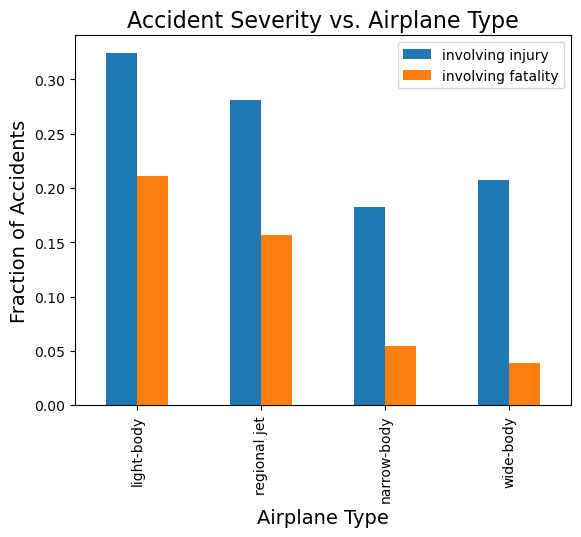

In [14]:
fig,ax=plt.subplots()

type_analysis = pd.DataFrame()

filter = (df["In.Production"]==True)

filter2 = (df["Total.Serious.Injuries"]>0) | (df["Total.Fatal.Injuries"]>0)

type_analysis["accident.all"] = df[filter].groupby("Aircraft.Type").count()["Event.Id"]
type_analysis["accident.serious"] = df[filter & filter2].groupby("Aircraft.Type").count()["Event.Id"]
type_analysis["accident.fatal"] = df[filter & df["Total.Fatal.Injuries"]>0].groupby("Aircraft.Type").count()["Event.Id"]

type_analysis["ratio.serious"] = type_analysis["accident.serious"]/type_analysis["accident.all"]
type_analysis["ratio.fatal"] = type_analysis["accident.fatal"]/type_analysis["accident.all"]

aircraft_type=["light-body","regional jet","narrow-body","wide-body"]
type_analysis.loc[aircraft_type,["ratio.serious","ratio.fatal"]].plot.bar(ax=ax)
type_analysis

ax.set_title("Accident Severity vs. Airplane Type", fontsize=16)
ax.set_xlabel("Airplane Type",fontsize=14)
ax.set_ylabel("Fraction of Accidents", fontsize=14)
ax.legend(["involving injury","involving fatality"])

fig.savefig("images/airplane_type.png",bbox_inches="tight")

### Accident Frequency vs. Make


Finally, we would like to consider whether Boeing or Airbus airplanes are involved in accidents more frequently.  We compare the relative number of Boeing and Airbus planes in service vs. the relative number of accidents they are involved in.
From the graph below, we see that Boeing aircraft are over-represented in the number of accidents logged by the top 3 carriers.  While 60% of the aircraft the carriers fleets are Boeing aircraft, 75% of accidents logged by the carries involved Boeing airplanes.

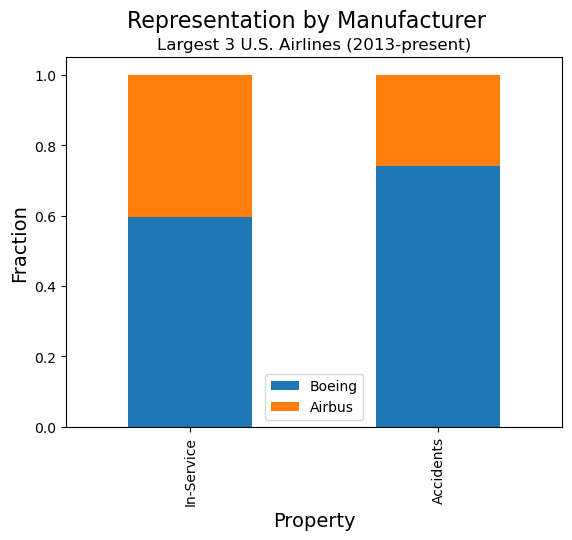

In [15]:
fig,ax=plt.subplots()
filter_carrier = df["Air.carrier"].map(lambda x: x in ["United Airlines","American Airlines","Delta Airlines"])

filter_year = df["Year"]>=2013
results=df[filter_carrier & filter_year].groupby("Make").count()

boeing_accidents=results.loc["Boeing","Event.Id"]
airbus_accidents=results.loc["Airbus","Event.Id"]

boeing_percent=boeing_accidents/(boeing_accidents+airbus_accidents)
airbus_percent=airbus_accidents/(boeing_accidents+airbus_accidents)

boeing_inservice=(505+61+53+96+71)+(133+48+298)+(71+57+59+188+70+30)
airbus_inservice=(81+85+12)+(365+67+59)+(88+240+121+64)

boeing_service_per = boeing_inservice/(boeing_inservice+airbus_inservice)
airbus_service_per = airbus_inservice/(boeing_inservice+airbus_inservice)



results = pd.DataFrame({"Boeing":[boeing_service_per,boeing_percent],
                        "Airbus":[airbus_service_per,airbus_percent]},index=["In-Service","Accidents"])

results.plot.bar(stacked=True, ax=ax)

ax.set_title("Largest 3 U.S. Airlines (2013-present)", fontsize=12)
fig.suptitle("Representation by Manufacturer", fontsize=16)
ax.set_xlabel("Property",fontsize=14)
ax.set_ylabel("Fraction", fontsize=14)
ax.legend(["Boeing","Airbus"])

fig.savefig("images/make_type.png",bbox_inches="tight")

## Conclusions

Based on this analysis, we can make these recommendations to help minimize the safety risk of an airplane purchase.  
- **Engine Type:** Select a Turbo Jet or Turbo Fan engine
- **Airplane Type:** Select a Narrow-Body or Wide-Body aircraft
- **Make:** Select an Airbus manufactured airplane.